# 2. Custom training

In TF101 we saw how we can define and train models through the Keras API. This is very convenient, but in some cases can be limiting. In this notebook we'll see how we can (a) build custom Neural Networks without involving Keras at all and (b) train these models without keras' `model.fit()` API.

In [1]:
import tensorflow as tf
assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

import time
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

2023-04-16 23:11:27.981074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 23:11:28.120871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-16 23:11:28.120888: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-16 23:11:28.785922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Building Neural Networks in TensorFlow (w/o Keras) 

Mimicking what we did in the first TF101 notebook, we'll try to recreate the same MLP and train it on the moons dataset.

First let's define the dataset. We'll change things a little bit though, to make the scenario more realistic. In large scale applications we cannot afford loading the whole training set in memory. Instead we have a generator producing a single batch at a time. This is the topic of the next notebook, though we will do our best to simulate this behavior in the moons dataset.

In [2]:
np.random.seed(13)


def moons_generator(batch_size=32, noise=0.2):
    '''
    Generator for producing a batch of 'moons' data
    '''
    while True:
        yield make_moons(batch_size, noise=noise)
    
    
x_train = moons_generator()
x_test = moons_generator()
# The names x_train and x_test are not accurate as these 
# generators return the labels along with the input features

The model we defined in keras is the following:

```python
inp = tf.keras.layers.Input(shape=(2,)) 
hid = tf.keras.layers.Dense(30, activation='relu')(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid)

mlp = tf.keras.models.Model(inp, out)
```

To recreate this in TensorFlow, we need to know that the `Dense` layer essentially performs the following operation

$$
z = f (X \cdot W + b)
$$

So, in turn the whole network does the following

$$
h = \text{ReLU} (X \cdot W_h + b_h) \\
\hat y = \sigma (h \cdot W_o + b_o)
$$

where $W_h, b_h, W_o, b_o$ are the weight and biases of the hidden and output layers respectively and $X$ is the model's input.

In [3]:
tf.random.set_seed(13)

# Hidden layer parameters
W_h = tf.Variable(tf.random.normal(shape=(2, 30)))  # shape=(input_features, hidden_layer_neurons)
b_h = tf.Variable(tf.random.normal(shape=(1, 30)))

# Output layer parameters
W_o = tf.Variable(tf.random.normal(shape=(30, 1)))  # shape=(hidden_layer_neurons, output)
b_o = tf.Variable(tf.random.normal(shape=(1, 1)))

# Create a list of all of the model's trainable parameters
trainable_params = [W_h, b_h, W_o, b_o]


# Hidden layer operations
def hidden(x):
    return tf.math.sigmoid(x @ W_h + b_h)  # @ --> matmul operator


# Output layer operations
def output(x):
    return tf.math.sigmoid(x @ W_o + b_o)


# Get a batch from the generator
x, y = next(x_train)


# Run predictions for random weights
hidden_layer_outputs = hidden(x)
y_hat = output(hidden_layer_outputs)

print('Predictions:')
print(y_hat)
print('Labels:')
print(y)

Predictions:
tf.Tensor(
[[0.93362725]
 [0.7597806 ]
 [0.50926185]
 [0.96909326]
 [0.9815643 ]
 [0.951013  ]
 [0.97385806]
 [0.6870211 ]
 [0.9766229 ]
 [0.6125538 ]
 [0.9129326 ]
 [0.94532955]
 [0.951406  ]
 [0.92570126]
 [0.8948641 ]
 [0.68440527]
 [0.7504297 ]
 [0.977184  ]
 [0.59780157]
 [0.8162962 ]
 [0.6382722 ]
 [0.9724078 ]
 [0.964869  ]
 [0.93438154]
 [0.5921625 ]
 [0.9243256 ]
 [0.9424068 ]
 [0.82952744]
 [0.9826905 ]
 [0.5754374 ]
 [0.7600825 ]
 [0.9289852 ]], shape=(32, 1), dtype=float32)
Labels:
[1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1]


2023-04-16 23:11:30.167677: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-16 23:11:30.167697: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-16 23:11:30.167714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (home): /proc/driver/nvidia/version does not exist
2023-04-16 23:11:30.167944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Let's measure the accuracy of this untrained classifier.

In [4]:
# Define accuracy function
def accuracy(y_true, y_pred):
    bin_preds = (y_pred > 0.5).numpy().astype(int).flatten()
    return np.sum(y_true == bin_preds) / len(y_true) 

# Compute the accuracy of the random classifier
acc = accuracy(y, y_hat)
print('Initial accuracy: {:.2f}%'.format(acc*100))

Initial accuracy: 50.00%


### Training our model

To make our life easier we'll define two functions to assist us during training and prediction. These two will perform the **forward** and **backward passes** for our network. The forward pass is the procedure that generates the prediction out of an input (i.e. the whole series of transformations from the beginning to the end of the network). The backward pass is the computation of the gradients of the loss w.r.t each one of the model's parameters.

In [5]:
def bce(y_true, y_pred):
    '''
    Compute the binary cross-entropy between y_true and y_pred
    '''
    return -tf.math.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))


def forward(x):
    '''
    Gererate the prediction for an input tensor x
    '''
    return output(hidden(x))


def backward(x, y):
    '''
    Compute the gradients for the loss w.r.t the model's trainable parameters,
    for an input tensor x
    '''
    with tf.GradientTape() as tape:
        y_hat = forward(x)
        loss = bce(y, y_hat)
    return tape.gradient(loss, trainable_params), loss

Let's run `backward()` to see what we get.

In [6]:
grads = backward(x, y)
grads

([<tf.Tensor: shape=(2, 30), dtype=float32, numpy=
  array([[-6.6126473e-02,  5.0442852e-02, -3.8183581e-02, -6.3892296e-03,
           6.5928483e-03, -6.5499179e-02, -5.8066577e-02,  7.2945543e-02,
          -5.2423910e-03, -7.0356302e-02,  4.7018182e-02, -6.3370340e-02,
           2.7766356e-02, -8.9933688e-04,  1.1129200e-01, -1.3603233e-02,
           8.8072853e-04,  2.1455297e-03,  1.4358440e-02, -3.9317971e-04,
          -1.6874094e-02,  8.0551594e-02, -4.9527781e-03, -1.0886554e-02,
          -5.7324495e-02,  1.4620623e-01,  1.2801398e-02, -2.2883579e-02,
          -2.7264878e-03,  1.4228658e-03],
         [-5.0796550e-03,  1.9862784e-02, -1.7627474e-02, -4.2240610e-03,
           1.1561638e-03, -1.1534214e-02, -1.1625479e-02,  1.1771051e-02,
          -1.2442167e-03, -5.3826235e-03,  1.4663624e-02, -1.2313918e-03,
           6.1133262e-03, -4.3967398e-04,  2.0463310e-02, -2.5429826e-03,
           5.6145922e-04,  6.3758274e-04,  2.6986217e-03, -7.4419848e-05,
          -5.72044

Essentially, we get a derivative for each parameter of the network. To train our, we'll use [**gradient descent**](https://en.wikipedia.org/wiki/Gradient_descent). The idea is to compute the partial derivative of the loss w.r.t the model's parameters (what we have done with the `GradientTape`) and update the parameters according to their partial derivative.

$$
w \leftarrow w - \lambda \frac{\partial L(y, \hat y)}{\partial w}
$$

where $w$ is a weight in the netowrk, $L$ is our loss function (BCE in our case) and $\lambda$ is the learning rate.

Note that the partial derivative of $L$ w.r.t $w$ shows the *direction* that $w$ needs to be changed to increase the loss the most. The opposite (i.e. $- \partial L / \partial w$), shows how to decrease the loss the most. That's why we want to update our parameters in that direction. 

In [7]:
def gd_update(trainable_parameters, gradients, lr=0.1):
    '''
    Apply a single step of Gradient Descent to the model's trainable parameters.
    
    i.e. 
    
        param = param - lr * grad 
    
    for every param, grad pair
    '''
    
    for p, g in zip(trainable_params, gradients):
        p.assign_sub(lr * g)

now we have all the components we need to build a custom training loop.

## Custom training loops

In TF101 we saw how we can easily train keras models through the `.fit()` API. This API essentially manages to **hide the training loop** from us, which is done intentionally to simplify the process of training Neural Networks.

What would normally be

```python
for e in range(epochs):
    for x, y in zip(x_train, y_train):
        # ...
        # train on batch
        # ...
```

in Keras becomes

```python
model.fit(x_train, y_train, epochs=epochs)
```

While this achieves a great deal of simplicity, it comes in the expense of **control**. To affect some aspects of the training process (e.g. learning rate) or to monitor variables, we need to use one of the existing or write a custom callback.

Still there are limitations to what we can affect or monitor through the use of callbacks! For this reason, in some cases we might want to train the model in a custom loop, where we have full control.

The fundamental steps we need to perform **at each iteration** are:

1. Generate the training **batch** (samples + labels).
2. Perform the **forward pass** and get the model's **predictions** for this batch.
3. Calculate the **loss** of these predictions compared to the actual labels.
4. Compute the loss' **gradients** w.r.t the model's trainable parameters (i.e. **backprop**).
5. **Update** the model's parameters according to the gradients (i.e. use the **optimizer**).

In [8]:
epochs = 20
steps_per_epoch = 10  # this normally is the amount of steps 
                      # it takes to exhaust the training set
val_steps_per_epoch = 5   # same but for the validataion set
learning_rate = 0.1
metrics = {'loss': [], 'val_loss': [], 'val_accuracy': []}


for e in range(epochs):
    
    # Here we normally would shuffle the training set
    
    # Training 
    for step in range(steps_per_epoch):
        
        x, y = next(x_train)  # get next batch from generator
        
        grads, loss = backward(x, y)  # forward and backward passes
        
        gd_update(trainable_params, grads, learning_rate)  # parameter updates
        
        metrics['loss'].append(loss.numpy())
        
        
    # Validataion
    for step in range(val_steps_per_epoch):
        tmp_loss, tmp_acc = [], []
        
        x, y = next(x_test)  # get batch from validataion data generator
        
        y_hat = forward(x)  # get the model's predicions
        
        # Compute the loss and accuracy for this batch
        tmp_loss.append(bce(y, y_hat).numpy())
        tmp_acc.append(accuracy(y, y_hat))
        
    # Aggregate over all batches    
    metrics['val_loss'].append(np.mean(tmp_loss))
    metrics['val_accuracy'].append(np.mean(tmp_acc))

Text(0.5, 1.0, 'Loss progression thourgh training')

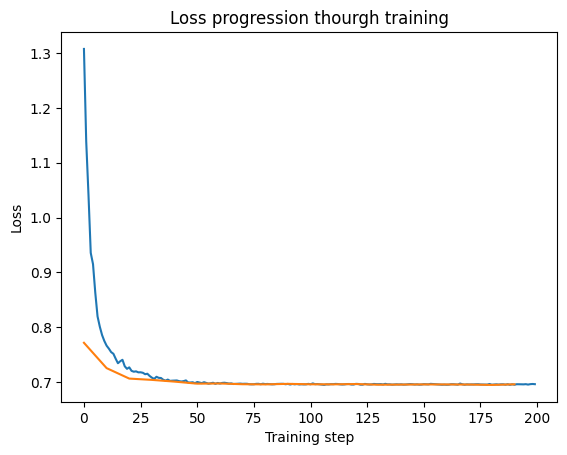

In [9]:
plt.plot(range(0, epochs * steps_per_epoch), metrics['loss'], label='train')
plt.plot(range(0, epochs * steps_per_epoch, steps_per_epoch), metrics['val_loss'], label='validation')

plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Loss progression thourgh training')

Obvisouly, we don't need to do everything from scratch (defining the loss function, doing the weight udpates, etc.). We can combine the flexibility of the custom training loop with the ease of defining models the Keras way.

In [10]:
inp = tf.keras.layers.Input(shape=(2,)) 
hid = tf.keras.layers.Dense(30, activation='relu')(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid)

mlp = tf.keras.models.Model(inp, out)

Let's start building the training logic. We'll first define a function that does a single training step for our model.

In [11]:
# Instead of defining the loss function, metrics, etc. ourselves we'll use the Keras ones

loss_function = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam()
accuracy = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
# The metrics in Keras have some big differences to the one we defined on our own, 
# but we'll ignore them for now...


# We'll now define a function that performs a single training step. We don't
# need to apply the tf.function decorator here, because this function isn't 
# intended to be a top-level function (i.e. it will be called from another).
def train_on_batch(x, y):
    '''
    Will train 'mlp' as defined in the global scope for a single training batch.
    The optimizer and loss function will also be taken from the global scope.
    '''
    
    # Start monitoring the operations in order to compute the gradient:
    with tf.GradientTape() as tape:

        # Generate the model's prediction:
        y_hat = mlp(x)

        # Calculate its loss:
        loss = loss_function(y, y_hat)

    # Compute the gradient of the loss w.r.t the model's parameters
    grads = tape.gradient(loss, mlp.trainable_variables)

    # Update the model's parameters through the optimizer
    optimizer.apply_gradients(zip(grads, mlp.trainable_variables))

    # Store the batch's accuracy
    acc = accuracy(tf.squeeze(y), tf.squeeze(y_hat))

    # Get the batch's loss so that we can plot it later
    return tf.reduce_mean(loss), tf.reduce_mean(acc)

Now we'll write a function that uses the previous to train the model for a number of epochs.

In [12]:
@tf.function
def train(train_data, epochs, validation_data=None):
    '''
    Train 'mlp' as defined in the global scope for a number of epochs, on a 
    given dataset. 
    '''

    for e in range(epochs):

        tf.print('Epoch {} of {}'.format(e+1, epochs))
    
        loss = 0.
        acc = 0.

        # Training epoch:
        for i, (x, y) in enumerate(train_data):

            # Perform a single iteration
            loss, acc = train_on_batch(x, y.reshape(-1, 1))

            # We need to manually keep track of the iteration,
            # because this generator will loop forever 
            if i >= steps_per_epoch:
                break

            if i % 100 == 0:
                tf.print('    Iteration:', i)
                tf.print('        Training loss:', loss)
                tf.print('        Training acc:', acc)

        if validation_data:

            valid_acc = 0.

            # Iterate over the validation set:
            for i, (x, y) in enumerate(validation_data):

                # Make a prediction and compute the mean of the accuracy and the loss
                preds = mlp(x)

                # Compute the mean accuracy of each batch and add them to 'valid_acc'
                valid_acc += accuracy(y, preds)

                # Again keep track of the iteration in order to terminate the loop
                if i >= val_steps_per_epoch:
                    break

            tf.print('    Validation accuracy:', valid_acc / tf.cast(i, tf.float32))

In [13]:
train(x_train, epochs=10, validation_data=x_test)

Epoch 1 of 10
    Iteration: 0
        Training loss: 0.782895923
        Training acc: 0.15625
    Validation accuracy: 0.31296739
Epoch 2 of 10
    Iteration: 0
        Training loss: 0.7483868
        Training acc: 0.263888896
    Validation accuracy: 0.367396921
Epoch 3 of 10
    Iteration: 0
        Training loss: 0.716344833
        Training acc: 0.316964298
    Validation accuracy: 0.434734792
Epoch 4 of 10
    Iteration: 0
        Training loss: 0.693190455
        Training acc: 0.373197109
    Validation accuracy: 0.486119419
Epoch 5 of 10
    Iteration: 0
        Training loss: 0.670165539
        Training acc: 0.413949281
    Validation accuracy: 0.541246414
Epoch 6 of 10
    Iteration: 0
        Training loss: 0.649497628
        Training acc: 0.459665686
    Validation accuracy: 0.591187537
Epoch 7 of 10
    Iteration: 0
        Training loss: 0.618050575
        Training acc: 0.499696612
    Validation accuracy: 0.631009281
Epoch 8 of 10
    Iteration: 0
        Training 

## TensorBoard and custom training loops

Training with a custom training loop gives us a greater flexibility in choosing what to log to TensorBoard and when. To log stuff to tensorboard, we use the `tf.summary` API.

There are two steps we need to do to use this API:
1. create a summary file writer
2. add the thing you want to log to this writer

`tf.summary` has different functions for the different things we want to write to TensorBoard, such as:
- `tf.summary.scalar`: log scalar values (e.g. metrics, losses).
- `tf.summary.histogram`: log histograms (e.g. histogram of weights, activations).
- `tf.summary.image`: log images. Can be used to log the output of generative models or even input images to see what the augmentations we are using actually look like.
- `tf.summary.text`: log text. Can be used in similar situations as the above.
- `tf.summary.audio`: log audio. Can be used in similar situations as the above.
- `tf.summary.graph`: log the TF computational graph. 

Let's see how these work. First we need to create the summary writer.

In [14]:
summary_writer = tf.summary.create_file_writer('logs/custom_loop')

### Logging scalars

The most common thing we want to log is scalar values. These can be losses, metrics or anything else we might want to log. 

In the example below we'll log 3 things:
- The value of the loss at each iteration
- The accuracy of our model at each iteration $^1$
- The value of the learning rate at each iteration. We will define an exponential decaying learning rate, so that we have something other than a constant line to plot.

$^1$ *Technically the Keras accuracy metric doesn't do exactly that; we'll explore this in a future notebook. For now let's assume that this is what it returns.*

In [15]:
# Re-initialize the components
loss_function = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam()
accuracy = tf.keras.metrics.BinaryAccuracy(threshold=0.5)


# Define an exponentially decaying LR
def build_exponentially_decayed_lr_func(initial_lr, decay_rate, decay_steps):
    '''
    Builds a function that given a training step, returns the value of the LR
    '''
    def lr_func(step):
        return initial_lr * decay_rate ** (step / decay_steps)

    return lr_func


lr_schedule = build_exponentially_decayed_lr_func(initial_lr=0.1, 
                                                  decay_rate=0.01,
                                                  decay_steps=100)


def log_scalars(loss, accuracy, lr, step):
    '''
    Log our metrics as scalars to the summary writer
    '''
    with summary_writer.as_default():
        tf.summary.scalar('loss', loss, step=step)
        tf.summary.scalar('accuracy', accuracy, step=step)
        tf.summary.scalar('learning_rate', lr, step=step)

This would play out something like this in our training loop:

```python
# Dummy training loop
for i, (x, y) in enumerate(x_train):


    lr = lr_schedule(i)                 # get new value of LR
    optimizer.learning_rate.assign(lr)  # change optimizer's LR

    loss, acc = train_on_batch(x, y.reshape(-1, 1))

    log_scalars(loss, acc, lr, i)  # log the scalars

    # Finish training after 100 steps
    if i >= 100:
        break
```


### Logging images

Another interesting thing we can do is to log actual images in TensorBoard. This is more useful in generative models that produce images. Nevertheless there can be other situations where this might be useful. In this example we'll plot a confusion matrix for our model and log it.

The example was adapted from [this blog](https://towardsdatascience.com/a-quickstart-guide-to-tensorboard-fb1ade69bbcf).

In [16]:
from sklearn.metrics import confusion_matrix
import itertools
import io


def plot_to_image(figure):
    '''
    Convert a matplotlib Figure to a png image
    '''
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)                    # Closing the figure prevents it from 
                                         # being displayed directly inside the notebook.
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image


def plot_confusion_matrix(cm):
    '''
    Plot a confusion matrix, given its values 
    '''
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm.T, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xticks([0, 1])
    plt.yticks([0, 1])

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[1]), range(cm.shape[0])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    return figure


def log_confusion_matrix(y_true, y_pred, step):
    '''
    Compute the confusion matrix for a binary classification task and
    log it to TensorBoard
    '''
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, (y_pred > 0.5).numpy().astype(int))
    
    # Plot it
    figure = plot_confusion_matrix(cm)
    
    # Convert it to an image
    cm_image = plot_to_image(figure)

    # Log this image to TensorBoard
    with summary_writer.as_default():
        tf.summary.image('Confusion Matrix', cm_image, step=step)

We would use the last function like this training loop:

```python
# Dummy training loop
for i, (x, y) in enumerate(x_train):

    loss, acc = train_on_batch(x, y.reshape(-1, 1))

    # Log the confusion matrix every 20 steps
    if i % 20 == 0:  
        y_hat = mlp(x)  # it would be better to modify 'train_on_batch' to
                        # return y_hat instead of needing to recompute it
        log_confusion_matrix(y, y_hat, i)

    # Finish training after 100 steps
    if i >= 100:
        break
```

### Logging histograms

In some cases where we want to debug or research our model's performance, we might want to visualize how training affects the distribution of some weight matrix, activation or gradient vector in the model. The best way to do this is through histograms.

We will do this for the weights, gradients of the first Dense layer in our MLP.

In [17]:
def log_dense_layer_histograms(step, grads):
    '''
    Log weights and gradient of the first hidden layer of our MLP
    '''
    weights = mlp.layers[1].get_weights()[0]
    grad = grads[0]
    
    with summary_writer.as_default():
        tf.summary.histogram('Weights (1st hidden layer)', weights, step=step)
        tf.summary.histogram('Gradient (1st hidden layer)', grad, step=step)

This would be used in a similar way to the previous two in our training loop:

```python
# Dummy training loop
for i, (x, y) in enumerate(x_train):

    loss, acc = train_on_batch(x, y.reshape(-1, 1))

    # Log the histograms every 10 steps
    if i % 10 == 0:  
        log_dense_layer_histograms(i, grad)

    # Finish training after 100 steps
    if i >= 100:
        break
```

### Example training loop with logging

Putting these previous use-cases together we can build a training loop that will log images, scalars and histograms. 

In [18]:
# Dummy training loop
for i, (x, y) in enumerate(x_train):


    lr = lr_schedule(i)                 # get new value of LR
    optimizer.learning_rate.assign(lr)  # change optimizer's LR

    loss, acc = train_on_batch(x, y.reshape(-1, 1))

    
    # Log the scalars
    log_scalars(loss, acc, lr, i)  
    
    # Log the confusion matrix every 20 steps
    if i % 20 == 0:  
        y_hat = mlp(x)  # it would be better to modify 'train_on_batch' to
                        # return y_hat instead of needing to recompute it
        log_confusion_matrix(y, y_hat, i)

    # Log the histograms every 10 steps
    if i % 10 == 0:  
        log_dense_layer_histograms(i, grads)

    # Finish training after 100 steps
    if i >= 100:
        break

In [19]:
%load_ext tensorboard
%tensorboard --logdir logs